In [1]:
import numpy as np
import random
from collections import deque
import matplotlib.pyplot as plt
import heapq
import pandas as pd

In [2]:
def seed_ship(D):    # seed the ship with a single open cell with ship size = D
    M = np.zeros((D,D),dtype=bool)
    rand_seed = (np.random.randint(0,D),np.random.randint(0,D))
    M[rand_seed] = True
    non0=[]
    non0.append((rand_seed))
    zero = []
    for i in range(M.shape[0]):
        for j in range(M.shape[1]):
            if M[i][j] == False:
                zero.append((i,j))
    # print(non0)
    return M, non0, zero

def neighbors(M,nz):   # utility function to find open and closed neighbors of a cell
    moves = ((-1,0), (0,-1), (1,0), (0,1))
    possible = [(nz[0]+i[0],nz[1]+i[1]) for i in moves]
    blocked_cells = []
    open_cells = []
    for i in possible:
        if i[0]>=0 and i[0]<M.shape[0] and i[1]>=0 and i[1]<M.shape[0]:
            if M[i] == False:
                blocked_cells.append(i)
            else:
                open_cells.append(i)

    return blocked_cells,open_cells

# Display the current state of the ship
def display_current(M, bot_position=[(0,0)], crew=[(0,0)], alien_positions=[(0,0)], path=[]):
    crewcount=1
    for i in range(M.shape[0]):
        for j in range(M.shape[1]):
            if (M[i][j] == False):
                print("⬛", end="")
            else:
                if (i,j) == bot_position[0]:
                    print("🤖", end="")
                elif (i,j) in crew:
                    if crewcount==1:
                        print("😨", end="")
                    if crewcount==2:
                        print("😥", end="")
                    crewcount+=1
                elif (i,j) in alien_positions:
                    print("💀",end="")
                elif (i,j) in path:
                    print("*️⃣",end="")
                else:
                    print("🟩",end="")
        print()

def gen_ship(M,open_cells,closed_cells):
    def closed_candidates():        # Figure out all possible closed cells that can be opened.
        candidates = []             # For all closed cells if they have exactly 1 open neighbor,
        for j in closed_cells:      # add those to a list from which later we choose one randomly to open
            _,on = neighbors(M,j)
            if len(on) == 1:
                candidates.append(j)
        return candidates
    candidates = closed_candidates()

    while len(candidates)>0:                   # Until the candidate list is exhausted, choose one random
        open_this = random.choice(candidates)  # candidate and open it, then calculate the list again.
        M[open_this] = True
        closed_cells.remove(open_this)
        open_cells.append(open_this)
        candidates = closed_candidates()

    dead_end_candidates = []                 # Figure out the list of dead ends.
    for i in open_cells:                     # Choose 1 neighbor of the DE at random and add it to the list
        cn,on = neighbors(M,i)
        if len(on) == 1 and len(cn)>0:
            open_this = random.choice(cn)
            dead_end_candidates.append(open_this)

    dead_end_candidates = set(dead_end_candidates) # remove duplicates
    dead_end_candidates = list(dead_end_candidates)
    random.shuffle(dead_end_candidates)             # For a random half of the dead ends,
    for j in range(len(dead_end_candidates)//2):    # open one closed neighbor each
        open_this = dead_end_candidates[j]
        if open_this not in closed_cells:
            print(open_this)
        M[open_this] = True
        closed_cells.remove(open_this)
        open_cells.append(open_this)

# Generate an adjacency list for the grid

def weight_adj_list(M,belief):
    ADJ = {}
    for i in range(M.shape[0]):
        for j in range(M.shape[1]):
            if M[i,j] == True:
                _, oc = neighbors(M,(i,j))
                for k in oc:
                    if (i,j) not in ADJ.keys():
                        ADJ[(i,j)] = [(k,belief[k[0],k[1]])]    #i,j --> k[0], k[1] should have the next node's weights
                    else:
                        ADJ[(i,j)].append((k,belief[k[0],k[1]]))
    return ADJ

def shortest_path(ADJ,bot_position,captain_position):   #Uses BFS to find the shortest path from the bot to the captain
    queue = deque()
    visited = []
    epic_tuple = bot_position  #a workaround due to a stupid error
    queue.append(epic_tuple)      #start with the position of the bot
    prev = {}
    path_exists = False
    while queue:
        now = queue.popleft()
        for child in ADJ[now]:
            if child not in visited:
                visited.append(now)
                queue.append(child)
                prev[child] = now
            if child == captain_position:
                path_exists = True
                break

    now = captain_position
    path = [captain_position]
    if not path_exists:
        return [bot_position,bot_position]
    if bot_position == captain_position:
        return path
    
    while prev[now] != bot_position:
        now = prev[now]
        path.append(now)

    path.append(bot_position)
    list.reverse(path)
    return path

def set_players(open_cells, num_aliens=1, num_crew=1):
    bot_position, crew_positions, alien_positions = [(0, 0)], [(0, 0)], [(0, 0)]

    if num_aliens >= len(open_cells):
        print("Too many aliens. The bot and captain will surely die")
        return bot_position, crew_positions, alien_positions

    bot_idx = random.choice(
        [i for i in range(len(open_cells))]
    )

    bot_position[0] = open_cells[bot_idx]
    crew_idx = [random.choice([i for i in range(len(open_cells)) if i not in [bot_idx]]) for _ in range(num_crew)]
    crew_positions = [open_cells[i] for i in crew_idx]

    alien_choice = []
    for i in range(num_aliens):
        for j in open_cells:
            if j not in crew_positions and j not in bot_position:
                alien_choice.append(j)

    alien_positions = [random.choice([i for i in alien_choice]) for _ in range(num_aliens)]

    return bot_position, crew_positions, alien_positions

def move_aliens(M, alien_positions, bot_position):
    random.shuffle(alien_positions)     #randomize alien actions to simulate their free will

    for i in range(len(alien_positions)):
        _,oc = neighbors(M, alien_positions[i])
        for j in oc:                    # for j in open neighbors
            if j in alien_positions:
                oc.remove(j)            # stop aliens from bumping into each other
        if len(oc)>=1:                  # if false, the alien stays in its place
            next_posi = random.choice(oc)
            alien_positions[i] = next_posi
    if bot_position[0] in alien_positions:
        return "bot died"
    else:
        return "nothing happened"

def a_star(start, goal, ADJ):
    # Priority queue: stores tuples of (estimated_cost, current_path_cost, node, path)
    priority_queue = [(0 + abs(start[0] - goal[0]) + abs(start[1] - goal[1]), 0, start, [start])]
    # Visited nodes to keep track of the minimum cost to reach a node
    visited = {start: 0}
    
    while priority_queue:
        # Get the current node with the lowest estimated cost
        estimated_cost, current_cost, current_node, path = heapq.heappop(priority_queue)
        
        # If the goal is reached, return the path
        if current_node == goal:
            return path
        
        # Explore neighbors
        try:
            for neighbor, cost in ADJ[current_node]:
                new_cost = current_cost + cost
                # If this path is better than any previous one, record it
                if neighbor not in visited or new_cost < visited[neighbor]:
                    visited[neighbor] = new_cost
                    new_path = path + [neighbor]
                    estimated_cost = new_cost + abs(neighbor[0] - goal[0]) + abs(neighbor[1] - goal[1])
                    heapq.heappush(priority_queue, (estimated_cost, new_cost, neighbor, new_path))
        except:
            return None
    return None  # If there's no path    

In [3]:
def bot1_move(M, bot_position, crew_positions, alien_positions,w):
    ADJ = weight_adj_list(M,w)
    path = a_star(bot_position[0], crew_positions[0], ADJ)
    if path is not None and len(path)>1:
        bot_position[0]=path[1]
        
    if bot_position[0] in crew_positions:
        return 'bot rescued the crew'
    if bot_position[0] in alien_positions:
        return 'bot died'
    else:
        return 'nothing happened'


### Bot 1 loop

In [15]:
iterations = 100
dim = 35
K_values = [i for i in range(1, 70)]
num_ships = 5
w = np.ones((dim,dim))
success_states = []
loss_states = []
stalemate_states = []
for ship in range(num_ships):
    M, open_cells, closed_cells = seed_ship(dim)
    gen_ship(M,open_cells,closed_cells)

    for k in K_values:
        bot_position, crew_positions, alien_positions = set_players(open_cells,num_aliens=k)
        state = 'nothing happened'
        for it in range(iterations):
            state = bot1_move(M, bot_position, crew_positions, alien_positions,w)
            if state == 'bot died':
                success_states.append((False, k, it))
                loss_states.append((True, k, it))
                stalemate_states.append((False, k, it))
                break

            if state == 'bot rescued the crew':
                success_states.append((True, k, it))
                loss_states.append((False, k, it))
                stalemate_states.append((False, k, it))
                break
            state = move_aliens(M, alien_positions, bot_position)
            
            if state == 'bot died':
                success_states.append((False, k, it))
                loss_states.append((True, k, it))
                stalemate_states.append((False, k, it))
                break

        if state == 'nothing happened':
            success_states.append((False, k, it))
            loss_states.append((False, k, it))
            stalemate_states.append((True, k, it))

In [16]:
success_states_bot1 = np.array(success_states)
loss_states_bot1 = np.array(loss_states)
stalemate_states_bot1 = np.array(stalemate_states)
np.save('data/success1.npy', success_states_bot1)
np.save('data/loss1.npy', loss_states_bot1)
np.save('data/stalemate1.npy', stalemate_states_bot1)

In [17]:
avg_success_rate = np.sum(success_states_bot1[:,0]) / success_states_bot1.shape[0]
avg_loss_rate = np.sum(loss_states_bot1[:,0]) / loss_states_bot1.shape[0]
avg_stalemate_rate = np.sum(stalemate_states_bot1[:,0]) / stalemate_states_bot1.shape[0]
print(avg_success_rate, avg_loss_rate, avg_stalemate_rate) 

0.336231884057971 0.663768115942029 0.0


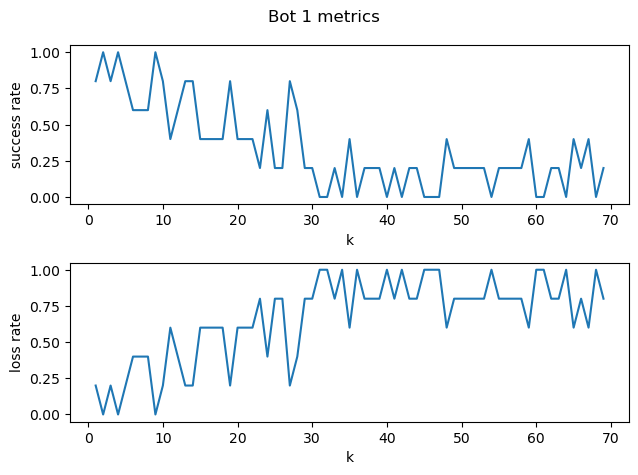

In [18]:
b1df_loss = pd.DataFrame(loss_states_bot1, columns=['Truth', 'k', 'iterations'])
b1df_stalemate = pd.DataFrame(stalemate_states_bot1, columns=['Truth', 'k', 'iterations'])
b1df_success = pd.DataFrame(success_states_bot1, columns=['Truth', 'k', 'iterations'])
success_per_k = []
loss_per_k = []
for i in K_values:
    success_per_k.append(b1df_success.loc[b1df_success['k'] == i]['Truth'].mean())
for i in K_values:
    loss_per_k.append(b1df_loss.loc[b1df_loss['k'] == i]['Truth'].mean())

fig, ax = plt.subplots(2,1)
ax[0].plot(K_values,success_per_k)
ax[0].set_xlabel("k")
ax[0].set_ylabel("success rate")
ax[1].plot(K_values, loss_per_k)
ax[1].set_xlabel("k")
ax[1].set_ylabel("loss rate")
fig.suptitle("Bot 1 metrics")
plt.tight_layout()
plt.show()

### Bot 2

In [19]:
def bot2_move(M, bot_position, crew_positions, alien_positions,w):
    ADJ = weight_adj_list(M,w)
    path = a_star(bot_position[0], crew_positions[0], ADJ)

    flag = False
    M_copy = M.copy()
    for alien in alien_positions:
        M_copy[alien[0], alien[1]] = False

    if path is not None:
        for cell in path:
            if cell in alien_positions:
                flag = True
                break
    
    if flag==True:
        ADJ = weight_adj_list(M_copy,w)
        path = a_star(bot_position[0], crew_positions[0], ADJ)

    # bot wont move if an alien blocks it's only path to the captain (when the alien is immediately in front of the bot)
    if path is not None and len(path)>1:
        if path[1] not in alien_positions:
            bot_position[0]=path[1]
        else:
            return 'nothing happened'
    if bot_position[0] in crew_positions:
        return 'bot rescued the crew'
    if bot_position[0] in alien_positions:
        return 'bot died'
    else:
        return 'nothing happened'

In [20]:
iterations = 100
dim = 35
K_values = [i for i in range(1, 70)]
num_ships = 5
w = np.ones((dim,dim))
success_states = []
loss_states = []
stalemate_states = []
for ship in range(num_ships):
    M, open_cells, closed_cells = seed_ship(dim)
    gen_ship(M,open_cells,closed_cells)

    for k in K_values:
        bot_position, crew_positions, alien_positions = set_players(open_cells,num_aliens=k)
        state = 'nothing happened'
        for it in range(iterations):
            state = bot2_move(M, bot_position, crew_positions, alien_positions,w)
            if state == 'bot died':
                success_states.append((False, k, it))
                loss_states.append((True, k, it))
                stalemate_states.append((False, k, it))
                break

            if state == 'bot rescued the crew':
                success_states.append((True, k, it))
                loss_states.append((False, k, it))
                stalemate_states.append((False, k, it))
                break
            state = move_aliens(M, alien_positions, bot_position)
            if state == 'bot died':
                success_states.append((False, k, it))
                loss_states.append((True, k, it))
                stalemate_states.append((False, k, it))
                break
        if state == 'nothing happened':
            success_states.append((False, k, it))
            loss_states.append((False, k, it))
            stalemate_states.append((True, k, it))

In [21]:
success_states_bot2 = np.array(success_states)
loss_states_bot2 = np.array(loss_states)
stalemate_states_bot2 = np.array(stalemate_states)
bot_number = 2
np.save(f'data/success{bot_number}.npy', success_states_bot2)
np.save(f'data/loss{bot_number}.npy', loss_states_bot2)
np.save(f'data/stalemate{bot_number}.npy', stalemate_states_bot2)

In [22]:
avg_success_rate = np.mean(success_states_bot2[:,0])
avg_loss_rate = np.mean(loss_states_bot2[:,0])
avg_stalemate_rate = np.mean(stalemate_states_bot2[:,0])
data = [avg_success_rate, avg_success_rate, avg_stalemate_rate]
print(avg_success_rate, avg_loss_rate, avg_stalemate_rate)


0.5739130434782609 0.4115942028985507 0.014492753623188406


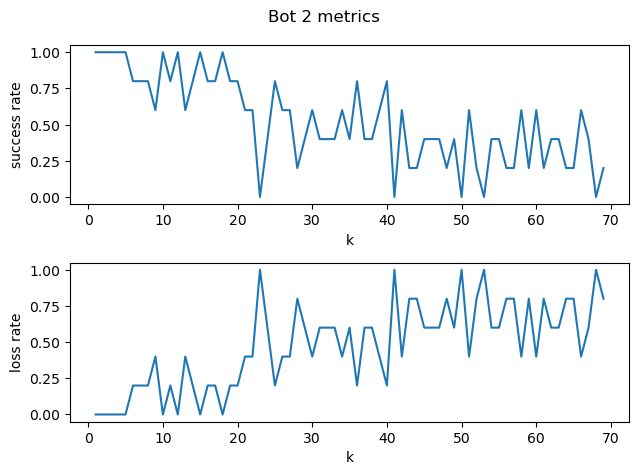

In [12]:
b2df_loss = pd.DataFrame(loss_states_bot2, columns=['Truth', 'k', 'iterations'])
b2df_stalemate = pd.DataFrame(stalemate_states_bot2, columns=['Truth', 'k', 'iterations'])
b2df_success = pd.DataFrame(success_states_bot2, columns=['Truth', 'k', 'iterations'])
success_per_k = []
loss_per_k = []
for i in K_values:
    success_per_k.append(b2df_success.loc[b2df_success['k'] == i]['Truth'].mean())
for i in K_values:
    loss_per_k.append(b2df_loss.loc[b2df_loss['k'] == i]['Truth'].mean())

fig, ax = plt.subplots(2,1)
ax[0].plot(K_values,success_per_k)
ax[0].set_xlabel("k")
ax[0].set_ylabel("success rate")
ax[1].plot(K_values, loss_per_k)
ax[1].set_xlabel("k")
ax[1].set_ylabel("loss rate")
fig.suptitle("Bot 2 metrics")
plt.tight_layout()
plt.show()

### Bot 3

In [13]:
def bot3_move(M, bot_position, crew_positions, alien_positions,w):
    ADJ = weight_adj_list(M,w)
    path = a_star(bot_position[0], crew_positions[0], ADJ)

    flag = False
    if path is not None:
        for cell in path:
            if cell in alien_positions:
                flag = True
                break
    M_copy = M.copy()
    
    if flag==True:
        for alien in alien_positions:
            M_copy[alien[0], alien[1]] = False
            _, oc = neighbors(M_copy, alien)
            candidate_block = []
            for cell in oc:
                candidate_block.append(cell)
                
            if len(candidate_block)>0:
                for cell in candidate_block:
                    M_copy[cell[0], cell[1]] = False

        ADJ = weight_adj_list(M_copy,w)
        path = a_star(bot_position[0], crew_positions[0], ADJ)

    if path is None:   # if no such path exists, resort to bot 2 tactics
        return bot2_move(M, bot_position, crew_positions, alien_positions,w)    

    # bot wont move if an alien blocks it's only path to the captain (when the alien is immediately in front of the bot)
    if path is not None and len(path)>1:
        if path[1] not in alien_positions:
            bot_position[0]=path[1]
        else:
            return 'nothing happened'
    if bot_position[0] in crew_positions:
        return 'bot rescued the crew'
    if bot_position[0] in alien_positions:
        return 'bot died'
    else:
        return 'nothing happened'

In [35]:
iterations = 100
dim = 35
K_values = [i for i in range(1, 70)]
num_ships = 5
w = np.ones((dim,dim))
success_states = []
loss_states = []
stalemate_states = []
for ship in range(num_ships):
    M, open_cells, closed_cells = seed_ship(dim)
    gen_ship(M,open_cells,closed_cells)

    for k in K_values:
        bot_position, crew_positions, alien_positions = set_players(open_cells,num_aliens=k)
        state = 'nothing happened'
        for it in range(iterations):
            state = bot3_move(M, bot_position, crew_positions, alien_positions,w)
            if state == 'bot died':
                success_states.append((False, k, it))
                loss_states.append((True, k, it))
                stalemate_states.append((False, k, it))
                break

            if state == 'bot rescued the crew':
                success_states.append((True, k, it))
                loss_states.append((False, k, it))
                stalemate_states.append((False, k, it))
                break
            
            state = move_aliens(M, alien_positions, bot_position)
            if state == 'bot died':
                success_states.append((False, k, it))
                loss_states.append((True, k, it))
                stalemate_states.append((False, k, it))
                break
            
        if state == 'nothing happened':
            success_states.append((False, k, it))
            loss_states.append((False, k, it))
            stalemate_states.append((True, k, it))

In [36]:
success_states_bot3 = np.array(success_states)
loss_states_bot3 = np.array(loss_states)
stalemate_states_bot3 = np.array(stalemate_states)
bot_number = 3
np.save(f'data/success{bot_number}.npy', success_states_bot3)
np.save(f'data/loss{bot_number}.npy', loss_states_bot3)
np.save(f'data/stalemate{bot_number}.npy', stalemate_states_bot3)

In [37]:
avg_success_rate = np.mean(success_states_bot3[:,0])
avg_loss_rate = np.mean(loss_states_bot3[:,0])
avg_stalemate_rate = np.mean(stalemate_states_bot3[:,0])
data = [avg_success_rate, avg_success_rate, avg_stalemate_rate]
print(avg_success_rate, avg_loss_rate, avg_stalemate_rate)


0.591304347826087 0.3884057971014493 0.020289855072463767


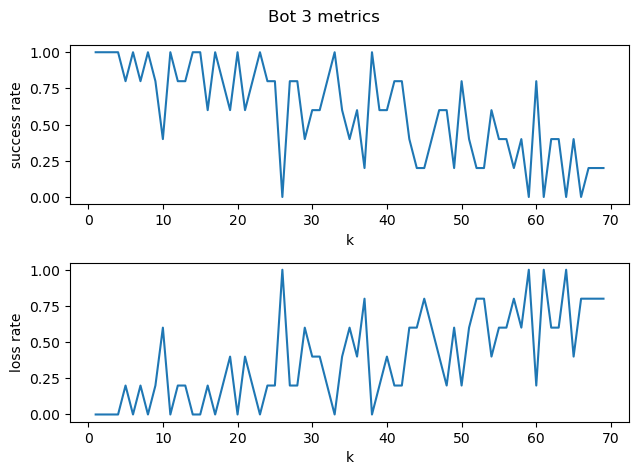

In [38]:
b3df_loss = pd.DataFrame(loss_states_bot3, columns=['Truth', 'k', 'iterations'])
b3df_stalemate = pd.DataFrame(stalemate_states_bot3, columns=['Truth', 'k', 'iterations'])
b3df_success = pd.DataFrame(success_states_bot3, columns=['Truth', 'k', 'iterations'])
success_per_k = []
loss_per_k = []
for i in K_values:
    success_per_k.append(b3df_success.loc[b3df_success['k'] == i]['Truth'].mean())
for i in K_values:
    loss_per_k.append(b3df_loss.loc[b3df_loss['k'] == i]['Truth'].mean())

fig, ax = plt.subplots(2,1)
ax[0].plot(K_values,success_per_k)
ax[0].set_xlabel("k")
ax[0].set_ylabel("success rate")
ax[1].plot(K_values, loss_per_k)
ax[1].set_xlabel("k")
ax[1].set_ylabel("loss rate")
fig.suptitle("Bot 3 metrics")
plt.tight_layout()
plt.show()

### Bot 4

In [27]:
def bot4_move(M, bot_position, crew_positions, alien_positions,w):
    ADJ = weight_adj_list(M,w)
    path = a_star(bot_position[0], crew_positions[0], ADJ)

    flag = False
    if path is not None:
        for cell in path:
            if cell in alien_positions:
                flag = True
                break
    M_copy = M.copy()
    
    if flag==True:
        for alien in alien_positions:
            M_copy[alien[0], alien[1]] = False
            _, oc = neighbors(M_copy, alien)
            candidate_block = []
            for cell in oc:
                candidate_block.append(cell)
                
            if len(candidate_block)>0:
                for cell in candidate_block:
                    M_copy[cell[0], cell[1]] = False

        ADJ = weight_adj_list(M_copy,w)
        _,oc = neighbors(M_copy, crew_positions[0])
        if len(oc) > 0:
            for cell in oc:
                path = a_star(bot_position[0], cell, ADJ)
                if path is not None:
                    break

    if path is None:   # if no such path exists, resort to bot 2 tactics
        return bot2_move(M, bot_position, crew_positions, alien_positions,w)    

    # bot wont move if an alien blocks it's only path to the captain (when the alien is immediately in front of the bot)
    if path is not None and len(path)>1:
        if path[1] not in alien_positions:
            bot_position[0]=path[1]
        else:
            return 'nothing happened'
    if bot_position[0] in crew_positions:
        return 'bot rescued the crew'
    if bot_position[0] in alien_positions:
        return 'bot died'
    else:
        return 'nothing happened'

In [28]:
iterations = 100
dim = 35
K_values = [i for i in range(1, 70)]
num_ships = 5
w = np.ones((dim,dim))
success_states = []
loss_states = []
stalemate_states = []
for ship in range(num_ships):
    M, open_cells, closed_cells = seed_ship(dim)
    gen_ship(M,open_cells,closed_cells)

    for k in K_values:
        bot_position, crew_positions, alien_positions = set_players(open_cells,num_aliens=k)
        state = 'nothing happened'
        for it in range(iterations):
            state = bot4_move(M, bot_position, crew_positions, alien_positions,w)
            if state == 'bot died':
                success_states.append((False, k, it))
                loss_states.append((True, k, it))
                stalemate_states.append((False, k, it))
                break

            if state == 'bot rescued the crew':
                success_states.append((True, k, it))
                loss_states.append((False, k, it))
                stalemate_states.append((False, k, it))
                break
            state = move_aliens(M, alien_positions, bot_position)
            if state == 'bot died':
                success_states.append((False, k, it))
                loss_states.append((True, k, it))
                stalemate_states.append((False, k, it))
                break
            
        if state == 'nothing happened':
            success_states.append((False, k, it))
            loss_states.append((False, k, it))
            stalemate_states.append((True, k, it))

In [29]:
success_states_bot4 = np.array(success_states)
loss_states_bot4 = np.array(loss_states)
stalemate_states_bot4 = np.array(stalemate_states)
bot_number = 4
np.save(f'data/success{bot_number}.npy', success_states_bot4)
np.save(f'data/loss{bot_number}.npy', loss_states_bot4)
np.save(f'data/stalemate{bot_number}.npy', stalemate_states_bot4)
avg_success_rate = np.mean(success_states_bot4[:,0])
avg_loss_rate = np.mean(loss_states_bot4[:,0])
avg_stalemate_rate = np.mean(stalemate_states_bot4[:,0])
data = [avg_success_rate, avg_success_rate, avg_stalemate_rate]
print(avg_success_rate, avg_loss_rate, avg_stalemate_rate)


0.6347826086956522 0.3507246376811594 0.014492753623188406


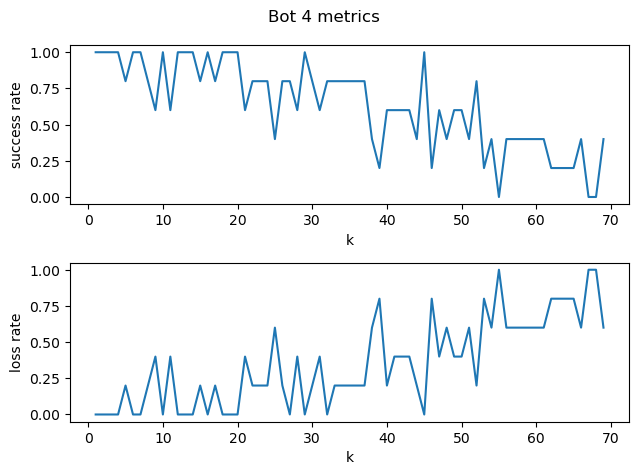

In [30]:
b4df_loss = pd.DataFrame(loss_states_bot4, columns=['Truth', 'k', 'iterations'])
b4df_stalemate = pd.DataFrame(stalemate_states_bot4, columns=['Truth', 'k', 'iterations'])
b4df_success = pd.DataFrame(success_states_bot4, columns=['Truth', 'k', 'iterations'])
success_per_k = []
loss_per_k = []
for i in K_values:
    success_per_k.append(b4df_success.loc[b4df_success['k'] == i]['Truth'].mean())
for i in K_values:
    loss_per_k.append(b4df_loss.loc[b4df_loss['k'] == i]['Truth'].mean())

fig, ax = plt.subplots(2,1)
ax[0].plot(K_values,success_per_k)
ax[0].set_xlabel("k")
ax[0].set_ylabel("success rate")
ax[1].plot(K_values, loss_per_k)
ax[1].set_xlabel("k")
ax[1].set_ylabel("loss rate")
fig.suptitle("Bot 4 metrics")
plt.tight_layout()
plt.show()

### Data comparison

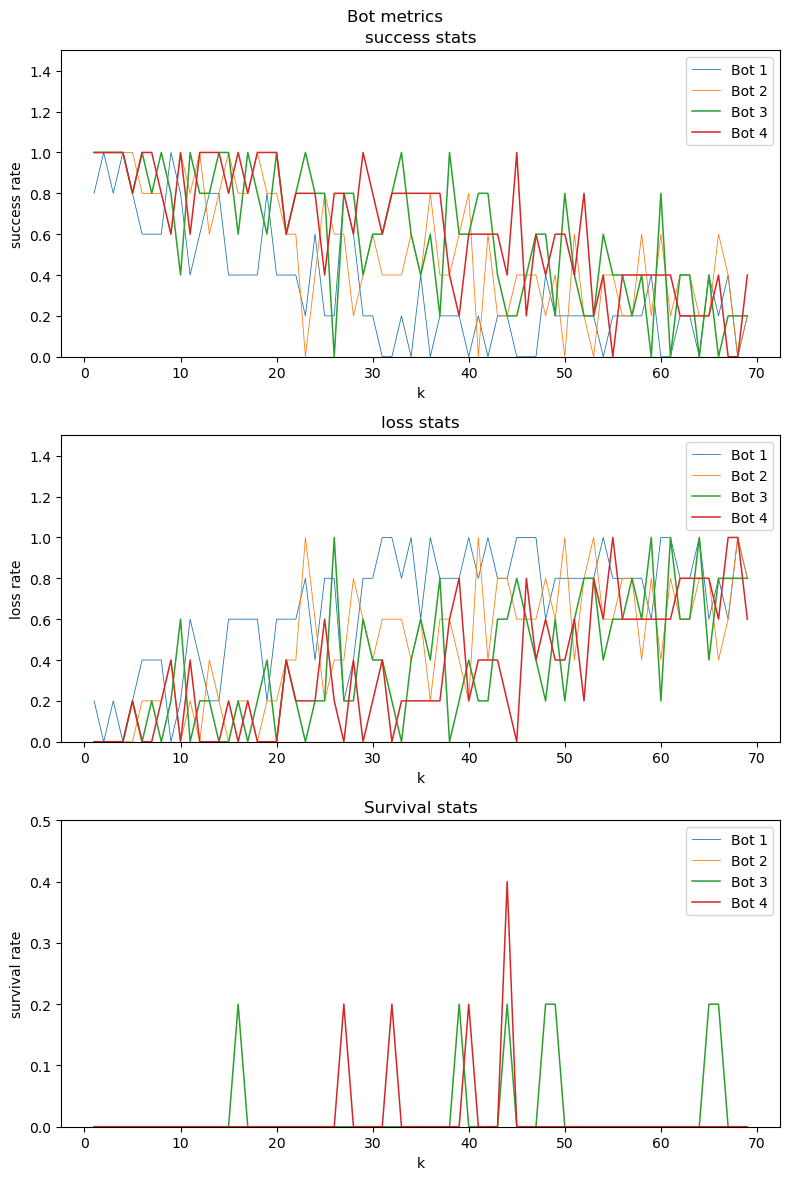

In [47]:
success_dfs = [b1df_success, b2df_success, b3df_success, b4df_success]
loss_dfs = [b1df_loss, b2df_loss, b3df_loss, b4df_loss]
survival = [b1df_stalemate, b2df_stalemate, b3df_stalemate, b4df_stalemate]

success = []
loss = []
stalemate = []

for bdf_success in success_dfs:
    success_per_k = [] 
    for i in K_values:
        success_per_k.append(bdf_success.loc[bdf_success['k'] == i]['Truth'].mean())
    success.append(success_per_k)
    
for bdf_loss in loss_dfs:
    loss_per_k = []
    for i in K_values:
        loss_per_k.append(bdf_loss.loc[bdf_loss['k'] == i]['Truth'].mean())
    loss.append(loss_per_k)

for bdf_stalemate in survival:
    stalemate_per_k = [] 
    for i in K_values:
        stalemate_per_k.append(bdf_stalemate.loc[bdf_stalemate['k'] == i]['Truth'].mean())
    stalemate.append(stalemate_per_k)
    
fig, ax = plt.subplots(3,1)
fig.set_size_inches(8,12)

for bot, s in enumerate(success):
    if bot in range(2,5):
        ax[0].plot(K_values,s, label=f'Bot {bot+1}', linewidth=1.1)
    else:
        ax[0].plot(K_values,s, label=f'Bot {bot+1}', linewidth=0.6)

ax[0].set_title("success stats")
ax[0].set_xlabel("k")
ax[0].set_ylabel("success rate")
ax[0].set_ylim(0,1.5)
ax[0].legend()
for bot, l in enumerate(loss):
    if bot in range(2,5):
        ax[1].plot(K_values,l, label=f'Bot {bot+1}', linewidth=1.1)
    else:
        ax[1].plot(K_values,l, label=f'Bot {bot+1}', linewidth=0.6)

ax[1].set_title("loss stats")
ax[1].set_xlabel("k")
ax[1].set_ylabel("loss rate")
ax[1].set_ylim(0,1.5)
ax[1].legend()

for bot, st in enumerate(stalemate):
    if bot in range(2,5):
        ax[2].plot(K_values,st, label=f'Bot {bot+1}', linewidth=1.1)
    else:
        ax[2].plot(K_values,st, label=f'Bot {bot+1}', linewidth=0.6)

ax[2].set_xlabel("k")
ax[2].set_ylabel("survival rate")
ax[2].set_title("Survival stats")
ax[2].set_ylim(0,0.5)
ax[2].legend()

fig.suptitle("Bot metrics")
plt.tight_layout()
plt.show()